### 1. Задание:
Предсказать тип ошибки программы по набору входящих данных.

Тип задания: Supervised Machine Learning - Classification 
Язык программирования: Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline

pd.options.display.max_info_columns = 999
pd.options.display.max_info_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_seq_items = 999
warnings.filterwarnings("ignore")

### Data loading
#### 1. Прочитать с помощью Pandas две таблицы 

In [2]:
commits = pd.read_csv('commits.csv')
issues = pd.read_csv('issues.csv')

In [3]:
commits.shape

(19226, 10)

In [4]:
commits.head()

,key,cid,author_name,author_email,committer_name,committer_email,time,time_offset,tree_id,message_encoding
0,SPARK-16904,57626a55703a189e03148398f67c36cd0e557044,gatorsmile,gatorsmile@gmail.com,Reynold Xin,rxin@databricks.com,1478510197,-480,0f4ae99e29245041cae4d41f58aa208dba6beea4,[SPARK-16904][SQL] Removal of Hive Built-in Ha...
1,SPARK-18296,9db06c442cf85e41d51c7b167817f4e7971bf0da,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478501095,-480,e6325a24125325611506a7fc0119209b88be17e3,[SPARK-18296][SQL] Use consistent naming for e...
2,SPARK-18167,07ac3f09daf2b28436bc69f76badd1e36d756e4d,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478500925,-480,525bd0fd99741a6a0e2bcfdd5c4e074f839b92a5,[SPARK-18167][SQL] Disable flaky hive partitio...
3,SPARK-18173,46b2e499935386e28899d860110a6ab16c107c0c,Wenchen Fan,wenchen@databricks.com,Reynold Xin,rxin@databricks.com,1478487433,-480,a27367a0be38e5a8814aac6295387f0457c603c8,[SPARK-18173][SQL] data source tables should s...
4,SPARK-18269,556a3b7d07f36c29ceb88fb6c24cc229e0e53ee4,hyukjinkwon,gurwls223@gmail.com,Reynold Xin,rxin@databricks.com,1478487125,-480,ba48a84dc34757cd6691b6a7ce9abdb615c4c1ac,[SPARK-18269][SQL] CSV datasource should read ...


In [5]:
commits.columns

Index(['key', 'cid', 'author_name', 'author_email', 'committer_name',
       'committer_email', 'time', 'time_offset', 'tree_id',
       'message_encoding'],
      dtype='object')

In [6]:
commits.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19226 entries, 0 to 19225
Data columns (total 10 columns):
key                 11476 non-null object
cid                 19226 non-null object
author_name         19226 non-null object
author_email        19226 non-null object
committer_name      19226 non-null object
committer_email     19226 non-null object
time                19226 non-null int64
time_offset         19226 non-null int64
tree_id             19226 non-null object
message_encoding    19226 non-null object
dtypes: int64(2), object(8)
memory usage: 1.5+ MB


In [7]:
commits[commits.key.isnull()]

,key,cid,author_name,author_email,committer_name,committer_email,time,time_offset,tree_id,message_encoding
8,NaN,15d392688456ad9f963417843c52a7b610f771d2,hyukjinkwon,gurwls223@gmail.com,Felix Cheung,felixcheung@apache.org,1478407653,-420,4a969525408e41c1bc971c9b79ab20ad741a3962,[MINOR][DOCUMENTATION] Fix some minor descript...
23,NaN,14f235d5643bca75e270652c15154d86e57a7a70,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478248026,-420,8b058a154a68bdd9c8d178730ba18aec68b10fd2,Closing some stale/invalid pull requests\n\nCl...
29,NaN,e89202523bc2f5573bd736278c6b96c6e6759909,wm624@hotmail.com,wm624@hotmail.com,Felix Cheung,felixcheung@apache.org,1478212038,-420,a3684731d25172d2f65001dc2018ca9d910fbee9,[SPARKR][TEST] remove unnecessary suppressWarn...
39,NaN,0ea5d5b24c1f7b29efeac0e72d271aba279523f7,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,1478166354,-420,4988c9ae3ce68ee6bfe8eb22627ce91fae48dcd4,[SQL] minor - internal doc improvement for Ins...
57,NaN,bcbe44440e6c871e217f06d2a4696fd41f1d2606,Maria Rydzy,majrydzy+gh@gmail.com,Sean Owen,sowen@cloudera.com,1478077756,0,9cc8b36446b564f704b2bd8f634420a2f7ed2098,[MINOR] Use <= for clarity in Pi examples' Mon...
85,NaN,623fc7fc67735cfafdb7f527bd3df210987943c6,Dongjoon Hyun,dongjoon@apache.org,Sean Owen,sowen@cloudera.com,1478005729,0,4b5ce899031779318a945226c083497d9534a51d,[MINOR][DOC] Remove spaces following slashs\n\...
93,NaN,26b07f1908eeffd934b1e86fb4de02f69945e004,Sean Owen,sowen@cloudera.com,Sean Owen,sowen@cloudera.com,1477908622,0,27440a5baa0cf0d3997ce4ccbd796785bb5822b9,[BUILD] Close stale Pull Requests.\n\nCloses #...
113,NaN,701a9d361b3045a25c42b3c0e44e7755d45ff78c,wm624@hotmail.com,wm624@hotmail.com,Sean Owen,sowen@cloudera.com,1477555237,120,5f9ba42a10eb311256b0ba3b36958532e9be46e6,[SPARK-CORE][TEST][MINOR] Fix the wrong commen...
114,NaN,44c8bfda793b7655e2bd1da5e9915a09ed9d42ce,Felix Cheung,felixcheung_m@hotmail.com,Felix Cheung,felixcheung@apache.org,1477548371,-420,4f42de29a093fe5f845307dca278a80d51bae96c,[SQL][DOC] updating doc for JSON source to lin...
125,NaN,ea3605e82545031a00235ee0f449e1e2418674e8,Yanbo Liang,ybliang8@gmail.com,Joseph K. Bradley,joseph@databricks.com,1477507734,-420,c26ab8a517d4210dcce914978b026bc936a24670,[MINOR][ML] Refactor clustering summary.\n\n##...


In [8]:
issues.shape

(17966, 16)

In [9]:
issues.head()

,key,jira_id,status_category,creator,priority,status,assignee,issuetype,reporter,resolution,project,updated,created,resolved,components,severity
0,SPARK-4957,12763687,Complete,nathan_gs,Major,Closed,None,Improvement,nathan_gs,None,Spark,2016-09-06T01:43:57.000+0000,2014-12-24T13:38:57.000+0000,2016-09-06T01:43:56.000+0000,Scheduler,3
1,SPARK-4956,12763679,Complete,liaoyuxi,Minor,Closed,None,Bug,liaoyuxi,None,Spark,2015-03-04T05:16:07.000+0000,2014-12-24T12:27:12.000+0000,2015-02-23T22:34:41.000+0000,MLlib,1
2,SPARK-4955,12763661,Complete,chengxiang li,Blocker,Closed,lianhuiwang,Bug,chengxiang li,None,Spark,2015-01-28T20:54:23.000+0000,2014-12-24T09:16:23.000+0000,2015-01-28T20:54:23.000+0000,YARN,10
3,SPARK-4954,12763657,Complete,liyezhang556520,Minor,Resolved,liyezhang556520,Improvement,liyezhang556520,None,Spark,2014-12-27T07:25:26.000+0000,2014-12-24T09:01:34.000+0000,2014-12-27T07:25:26.000+0000,Spark Core,1
4,SPARK-4953,12763643,Complete,sarutak,Major,Resolved,sarutak,Bug,sarutak,None,Spark,2014-12-25T15:06:12.000+0000,2014-12-24T07:07:56.000+0000,2014-12-25T15:06:12.000+0000,Documentation,3


In [10]:
commits.dropna(subset=['key'], inplace=True)

In [11]:
commits.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11476 entries, 0 to 19211
Data columns (total 10 columns):
key                 11476 non-null object
cid                 11476 non-null object
author_name         11476 non-null object
author_email        11476 non-null object
committer_name      11476 non-null object
committer_email     11476 non-null object
time                11476 non-null int64
time_offset         11476 non-null int64
tree_id             11476 non-null object
message_encoding    11476 non-null object
dtypes: int64(2), object(8)
memory usage: 986.2+ KB


### Data merging
#### 2. Объединить таблицы по полю Key.

In [12]:
df = commits.merge(issues, on='key', how='inner')

In [13]:
df.shape

(11475, 25)

#### 3. Выбрать столбцы:
    • 'author_name' – имя автора коммита;
    • 'author_email' – почта автора коммита;
    • 'committer_name' – имя исполнителя;
    • 'committer_email' – почта исполнителя;
    • 'time' – время коммита;
    • 'time_offset' – отклонение во времени;
    • 'message_encoding' – текст коммита.
как независимые переменные, и столбец
    • ‘severity’ – степень ошибки как зависимую переменную для предсказания.
    
    Add feature 'components'

In [14]:
print (df[ 'components'].unique())
len(df[ 'components'].unique())

['SQL' 'ML' 'SparkR' 'SQL,Structured Streaming' 'Tests' nan 'Spark Core'
 'GraphX' 'Structured Streaming' 'YARN' 'ML,PySpark' 'Spark Core,SQL'
 'SQL,Tests' 'Build' 'Spark Core,YARN' 'PySpark,SparkR,SQL'
 'MLlib,Spark Core,SQL' 'Web UI'
 'Documentation,DStreams,Structured Streaming' 'DStreams' 'Mesos'
 'PySpark' 'ML,SparkR' 'MLlib' 'Examples,ML' 'Examples' 'SparkR,SQL'
 'ML,MLlib' 'Spark Core,Web UI' 'Scheduler' 'MLlib,Tests' 'Deploy'
 'Project Infra' 'MLlib,Spark Core' 'DStreams,SQL' 'Documentation'
 'Shuffle' 'PySpark,SQL' 'Optimizer' 'Spark Submit' 'Scheduler,YARN'
 'Shuffle,Spark Core' 'Input/Output' 'ML,MLlib,PySpark'
 'Documentation,SparkR' 'Build,SparkR' 'SQL,Web UI'
 'Block Manager,Spark Core' 'Documentation,Tests' 'Scheduler,Spark Core'
 'Build,DStreams' 'Block Manager' 'Build,Documentation'
 'PySpark,Spark Core' 'PySpark,Spark Submit,YARN' 'Tests,YARN'
 'Java API,PySpark,Web UI' 'MLlib,SparkR' 'Build,Project Infra'
 'SparkR,Tests' 'MLlib,SQL' 'Documentation,SQL' 'MLlib,PySpark

259

In [15]:
df = df[['author_name', 'author_email', 'committer_name' , 'committer_email' ,
        'time', 'time_offset', 'message_encoding','components', 'severity']]

### Data cleaning & feature engineering

In [16]:
df['time'] = pd.to_datetime(df['time'], unit='s') 
df['year'] = df['time'].apply(lambda x: x.year)
df['month'] = df['time'].apply(lambda x: x.month)
df['day'] = df['time'].apply(lambda x: x.day)
df['weekday'] = df['time'].apply(lambda x: datetime.weekday(x))
df['hour'] = df['time'].apply(lambda x: x.hour)

df['date_month'] = df['time'].apply(lambda x: datetime.strftime(x.date(),"%Y-%m"))

In [17]:
df['head_message'] = df.message_encoding.apply(lambda x: x.splitlines()[0])
df['head_message'] = [re.sub("[\[].*?[\]]", "", x).strip() for x in df['head_message'].values]

In [18]:
df['author_email_domain'] = df['author_email'].apply(lambda x: '' if len(x.split("@")) == 1 else x.split("@")[1])

In [19]:
df['committer_email_domain'] = df['committer_email'].apply(lambda x: '' if len(x.split("@")) == 1 else x.split("@")[1])

In [20]:
df.head()

,author_name,author_email,committer_name,committer_email,time,time_offset,message_encoding,components,severity,year,month,day,weekday,hour,date_month,head_message,author_email_domain,committer_email_domain
0,gatorsmile,gatorsmile@gmail.com,Reynold Xin,rxin@databricks.com,2016-11-07 09:16:37,-480,[SPARK-16904][SQL] Removal of Hive Built-in Ha...,SQL,3,2016,11,7,0,9,2016-11,Removal of Hive Built-in Hash Functions and Te...,gmail.com,databricks.com
1,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,2016-11-07 06:44:55,-480,[SPARK-18296][SQL] Use consistent naming for e...,SQL,3,2016,11,7,0,6,2016-11,Use consistent naming for expression test suites,databricks.com,databricks.com
2,Reynold Xin,rxin@databricks.com,Reynold Xin,rxin@databricks.com,2016-11-07 06:42:05,-480,[SPARK-18167][SQL] Disable flaky hive partitio...,SQL,3,2016,11,7,0,6,2016-11,Disable flaky hive partition pruning test.,databricks.com,databricks.com
3,Eric Liang,ekl@databricks.com,Yin Huai,yhuai@databricks.com,2016-11-04 22:54:28,-420,[SPARK-18167] Re-enable the non-flaky parts of...,SQL,3,2016,11,4,4,22,2016-11,Re-enable the non-flaky parts of SQLQuerySuite,databricks.com,databricks.com
4,Eric Liang,ekl@databricks.com,Reynold Xin,rxin@databricks.com,2016-11-01 19:35:34,-420,[SPARK-18167] Disable flaky SQLQuerySuite test...,SQL,3,2016,11,1,1,19,2016-11,Disable flaky SQLQuerySuite test,databricks.com,databricks.com


In [21]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11475 entries, 0 to 11474
Data columns (total 18 columns):
author_name               11475 non-null object
author_email              11475 non-null object
committer_name            11475 non-null object
committer_email           11475 non-null object
time                      11475 non-null datetime64[ns]
time_offset               11475 non-null int64
message_encoding          11475 non-null object
components                10926 non-null object
severity                  11475 non-null int64
year                      11475 non-null int64
month                     11475 non-null int64
day                       11475 non-null int64
weekday                   11475 non-null int64
hour                      11475 non-null int64
date_month                11475 non-null object
head_message              11475 non-null object
author_email_domain       11475 non-null object
committer_email_domain    11475 non-null object
dtypes: datetime64[ns](1),

### Exploratory Data Analysis
#### 4. Провести статистический анализ данных (exploratory data analysis), используя произвольные тип визуализации, в частности, сколько коммитов в день делает пользователь и т.д. 

In [22]:
plt.style.use('ggplot')

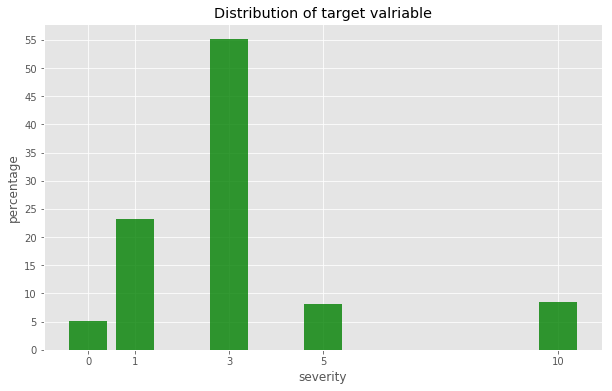

In [23]:
fig = plt.figure(figsize = (10,6))
x = df['severity'].unique()
h = 100*df['severity'].value_counts(1).values
plt.bar(x, h, color='green', alpha = 0.8)
plt.xlabel("severity")
plt.ylabel("percentage")
plt.title("Distribution of target valriable")
plt.xticks(x)
plt.yticks(range(0, int(round(max(h),0)+5) ,5))
plt.show()

As we can see classes are not balanced.

In [24]:
len(df.committer_name.unique()) # count of committers

61

In [25]:
commiters = df.committer_name.value_counts()[df.committer_name.value_counts() >= 10].index
table = pd.pivot_table(df[['committer_name', 'severity']][df.committer_name.isin(commiters)], 
                       index='committer_name', columns='severity', aggfunc=len, fill_value=0)

In [26]:
table

severity,0,1,3,5,10
committer_name,,,,,
Aaron Davidson,0,23,46,4,8
Andrew Or,30,207,460,102,64
Ankur Dave,4,9,11,4,1
Cheng Lian,3,55,169,41,54
DB Tsai,5,24,33,4,0
Davies Liu,8,72,399,50,43
Felix Cheung,0,5,25,0,1
Herman van Hovell,5,38,70,7,6
Imran Rashid,3,12,17,3,1


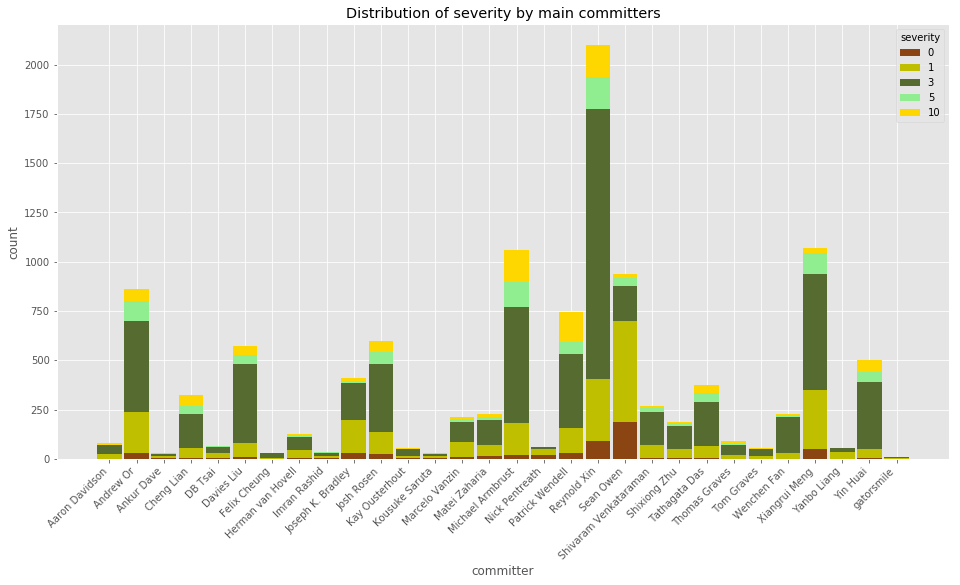

In [27]:
fig = plt.figure(figsize = (16,8))
bars0 = table[0]
bars1 = table[1]
bars3 = table[3]
bars5 = table[5]
bars10 = table[10]

r = range(1, len(table)+1)

names = table.index
barWidth = 0.9

plt.bar(r, bars0, color='saddlebrown', width=barWidth)
plt.bar(r, bars1, bottom=bars0, color='y', width=barWidth)
plt.bar(r, bars3, bottom=bars1+bars0, color='darkolivegreen', width=barWidth)
plt.bar(r, bars5, bottom=bars3+bars1+bars0, color='lightgreen', width=barWidth)
plt.bar(r, bars10, bottom=bars5+bars3+bars1+bars0, color='gold', width=barWidth)

plt.title("Distribution of severity by main committers")
plt.xticks(r, names, rotation=45, ha='right')
plt.legend(['0', '1', '3', '5', '10'], title="severity")
plt.xlabel("committer")
plt.ylabel("count")

plt.show()

 Reynold Xin made more committs than others. Sean Owen works best and Michael Armbrust has the highest percentage of commits with severity=10.

In [28]:
committer_email_domains = df.committer_email_domain.value_counts()[df.committer_email_domain.value_counts() >= 2].index
table1 = pd.pivot_table(df[['committer_email_domain', 'severity']][df.committer_email_domain.isin(committer_email_domains)], 
                       index='committer_email_domain', columns='severity', aggfunc=len, fill_value=0)

In [29]:
table1

severity,0,1,3,5,10
committer_email_domain,,,,,
HW11853.local,0,1,1,0,0
admobius.com,0,0,2,0,0
apache.org,20,100,345,45,42
cloudera.com,199,601,302,61,29
cs.berkeley.edu,6,66,172,21,12
databricks.com,257,1439,4304,681,631
dbtsai.com,1,0,1,0,0
eecs.berkeley.edu,7,18,48,3,1
gmail.com,62,353,1027,152,224


In [30]:
len(df.components.unique()) # count of components

259

In [31]:
components = df.components.value_counts()[df.components.value_counts() >= 5].index
table2 = pd.pivot_table(df[['components', 'severity']][df.components.isin(components)], 
                       index='components', columns='severity', aggfunc=len, fill_value=0)

In [32]:
table2['total'] = table2.iloc[:,:5].sum(axis=1).astype(int)

In [33]:
table2

severity,0,1,3,5,10,total
components,,,,,,
Block Manager,0,9,25,1,3,38
"Block Manager,Spark Core",0,1,17,3,0,21
Build,26,104,141,13,31,315
"Build,Deploy",0,3,2,0,0,5
"Build,Documentation",1,4,1,1,0,7
"Build,ML",0,1,4,0,5,10
"Build,Project Infra",0,3,16,3,0,22
"Build,SQL",1,5,1,3,3,13
"Build,Spark Core",0,0,18,2,1,21


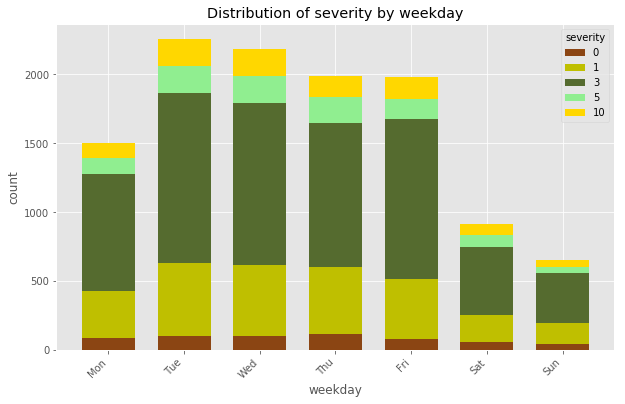

In [34]:
table_weekday = pd.pivot_table(df[['weekday', 'severity']], index='weekday', columns='severity', aggfunc=len, fill_value=0)

fig = plt.figure(figsize = (10,6))
bars0 = table_weekday[0]
bars1 = table_weekday[1]
bars3 = table_weekday[3]
bars5 = table_weekday[5]
bars10 = table_weekday[10]

r = range(1, len(table_weekday)+1)

names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
barWidth = 0.7

plt.bar(r, bars0, color='saddlebrown', width=barWidth)
plt.bar(r, bars1, bottom=bars0, color='y', width=barWidth)
plt.bar(r, bars3, bottom=bars1+bars0, color='darkolivegreen', width=barWidth)
plt.bar(r, bars5, bottom=bars3+bars1+bars0, color='lightgreen', width=barWidth)
plt.bar(r, bars10, bottom=bars5+bars3+bars1+bars0, color='gold', width=barWidth)

plt.title("Distribution of severity by weekday")
plt.xticks(r, names, rotation=45, ha='right')
plt.legend(['0', '1', '3', '5', '10'], title="severity")
plt.xlabel("weekday")
plt.ylabel("count")

plt.show()

In [35]:
table_commits = pd.pivot_table(df[['date_month','severity']], index='date_month', columns='severity', aggfunc=len, fill_value=0)
table_commits['total'] = table_commits.iloc[:,:5].sum(axis=1).astype(int)

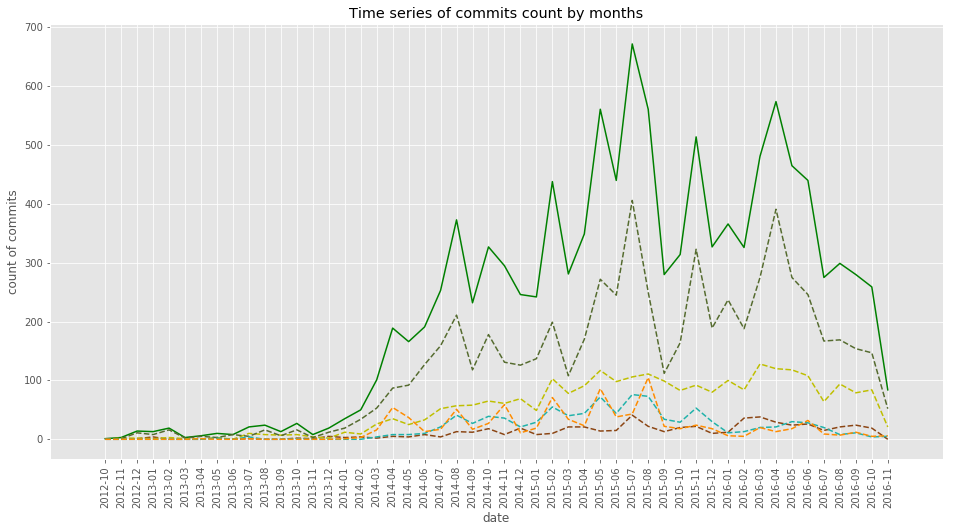

In [36]:
ax = plt.axes()

table_commits.total.plot(figsize = (16,8), ax=ax, color='g', style='-') 
table_commits[0].plot(ax=ax, color='saddlebrown', style='--')
table_commits[1].plot(ax=ax, color='y', style='--')
table_commits[3].plot(ax=ax, color='darkolivegreen', style='--')
table_commits[5].plot(ax=ax, color='lightseagreen', style='--')
table_commits[10].plot(ax=ax, color='darkorange', style='--')
                   
plt.xticks(np.arange(len(table_commits)),  table_commits.index, rotation=90)
ax.set_xlim(np.array([-1, 1])+ax.get_xlim())
plt.title('Time series of commits count by months')
plt.xlabel('date')
plt.ylabel('count of commits')

plt.show()

Based on the graph, we can assume that data shows the performance of some project.              
At the beginning and at the end of the time series, the number of commits is lower than in the middle of period.              Sharp variations in data may indicate a performance of sprints.

### Prepare input for models
#### 6. Превратить категорийные текстовые переменные в числовые.

In [37]:
cat_columns = ['author_name', 'committer_name', 'author_email_domain', 'committer_email_domain', 
              'components', 'year']
X = df[['month', 'day', 'weekday', 'hour', 'time_offset']]
def labelEncoding(df, X, cat_columns):
    for col_name in cat_columns:
        lb = LabelEncoder()
        X[col_name + '_enc'] = lb.fit_transform(df[col_name].fillna('None'))

In [38]:
labelEncoding(df, X, cat_columns)

In [39]:
X.head()

,month,day,weekday,hour,time_offset,author_name_enc,committer_name_enc,author_email_domain_enc,committer_email_domain_enc,components_enc,year_enc
0,11,7,0,9,-480,830,42,116,5,212,4
1,11,7,0,6,-480,566,42,84,5,212,4
2,11,7,0,6,-480,566,42,84,5,212,4
3,11,4,4,22,-420,201,54,84,5,212,4
4,11,1,1,19,-420,201,42,84,5,212,4


In [40]:
y = df.severity.copy()

In [41]:
y.isnull().sum()

0

### Text features
#### 7. Превратить некатегорийные текстовые переменные в векторы любым оптимальным способом. В случае необходимости, Вы можете дополнять dataset дополнительными переменными.

In [42]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1), use_idf=False)
X_message_encoding_tfidf = vectorizer.fit_transform(df['message_encoding'])

In [43]:
vectorizer = CountVectorizer()
X_message_encoding_count = vectorizer.fit_transform(df['message_encoding'])

In [44]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
X_head_message_tfidf = vectorizer.fit_transform(df['head_message'])

In [45]:
X_len_texts = pd.DataFrame()
X_len_texts['message_lines_count'] = df.message_encoding.apply(lambda x: len(x.splitlines()))

In [46]:
X_len_texts['message_len_text'] = df.message_encoding.apply(len)

In [47]:
X_len_texts['head_message_len_text'] = df.head_message.apply(len)

In [48]:
X_len_texts.describe()

,message_lines_count,message_len_text,head_message_len_text
count,11475.000,11475.000,11475.000
mean,16.905,843.087,51.226
std,20.110,1324.808,18.541
min,1.000,18.000,0.000
25%,9.000,366.000,38.000
50%,13.000,553.000,49.000
75%,18.000,898.500,62.000
max,1006.000,70343.000,170.000


Consider 4 different inputs for modelling:
    <br>
    Х1 - features+len_text+tfidft_vectorizer
    <br>
    X2 - features +count_vectorizer
    <br>
    X3 - features+len_text+tfidf_head_message
    <br>
    X4 - features+len_text

In [49]:
X1 = hstack((pd.concat([X, X_len_texts], axis=1), X_message_encoding_tfidf))

In [50]:
X1.shape

(11475, 72406)

In [51]:
X2 = hstack((X, X_message_encoding_count)).astype(float)

In [52]:
X2.shape

(11475, 72680)

In [53]:
X3 = hstack(((pd.concat([X, X_len_texts], axis=1), X_head_message_tfidf)))

In [54]:
X3.shape

(11475, 8469)

In [55]:
X4 = pd.concat([X, X_len_texts], axis=1)

### Modelling
#### 8. Разделить dataset на train и test части. 

In [56]:
x1_train, x1_test, x2_train, x2_test, x3_train, x3_test, x4_train, x4_test, x_text_train, x_text_test, y_train, y_test = train_test_split(X1, X2, X3, X4, X_message_encoding_tfidf, 
                                                                               y, test_size=0.2, random_state=1, stratify=y)

#### 9. Построить модель, которая будет предсказывать переменную severity для тестового dataset на основании данных в train dataset. 
#### 10. Протестировать несколько моделей и выбрать из них лучшую. А именно: 
- использовать Sklearn библиотеку (модели: Random Forest, Decision trees, Naive Bayes, SVM, etc.)
- использование нейронных сетей будет плюсом. Можна взять Keras.io и натренировать нейронную сеть (выбрать Fully Connected Layer или другую архитектуру).

#### 11. Оптимизировать модели с использованием cross validation, grid search, etc.
#### 12. Оценить эффективность моделей на test datataset с использованием нескольких метрик на Ваше усмотрение и указать наиболее эффективную модель.
#### 13. Визуализировать confusion matrix для сравнения результатов.
#### 14. Кратко описать полученные результаты и их сравнение на английском языке. Выразить свое мнение, почему некоторые модели работают лучше или хуже.

In [57]:
def Report(y_train, y_test, train_predicted, test_predicted):
    accuracy_train = accuracy_score(y_train, train_predicted)
    accuracy_test = accuracy_score(y_test, test_predicted)
    report = classification_report(y_test, test_predicted)
    cm = confusion_matrix(y_test, test_predicted)

    print("Accuracy: "+"\n"+ "on train set"+" "+str(accuracy_train)+"\n"+ "on test set", accuracy_test)
    print("Report: "+"\n"+ report)
    print("Count of true predictions: ", cm.diagonal().sum())

    labels = sorted(y_test.unique())
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig = plt.figure(figsize=(10, 6))
    heatmap = sns.heatmap(df_cm, annot=True, cmap='PuRd', 
                      linewidths=.5, linecolor='gray',fmt="d", cbar_kws={"orientation": "vertical"})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

##### RandomForest

Accuracy: 
on train set 0.9645969498910676
on test set 0.5568627450980392
Report: 
             precision    recall  f1-score   support

          0       0.24      0.11      0.15       115
          1       0.43      0.39      0.41       532
          3       0.62      0.80      0.70      1265
          5       0.25      0.07      0.11       195
         10       0.40      0.15      0.22       188

avg / total       0.51      0.56      0.52      2295

Count of true predictions:  1278


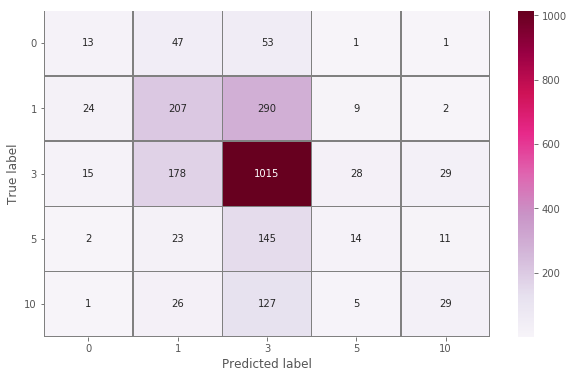

Wall time: 407 ms


In [58]:
%%time

forest_clf = RandomForestClassifier(n_estimators=10, max_depth=30, random_state=1)
forest_clf.fit(x4_train, y_train)
test_predicted_forest = forest_clf.predict(x4_test)
train_predicted_forest = forest_clf.predict(x4_train)

Report(y_train, y_test, train_predicted_forest, test_predicted_forest)

#### *Decision Tree*

Accuracy: 
on train set 0.9221132897603486
on test set 0.5237472766884531
Report: 
             precision    recall  f1-score   support

          0       0.24      0.14      0.18       115
          1       0.42      0.42      0.42       532
          3       0.63      0.71      0.67      1265
          5       0.18      0.13      0.15       195
         10       0.28      0.21      0.24       188

avg / total       0.50      0.52      0.51      2295

Count of true predictions:  1202


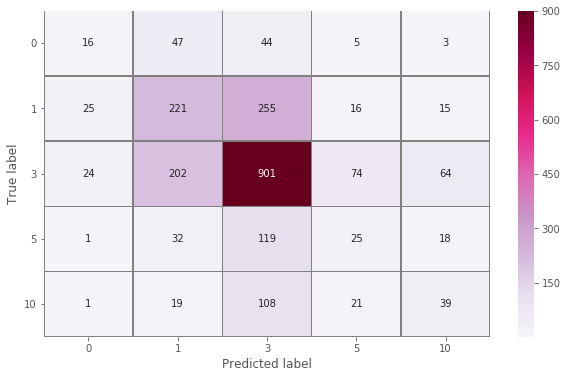

Wall time: 8.69 s


In [59]:
%%time

tree = DecisionTreeClassifier(max_depth=50, random_state=1)
tree.fit(x2_train, y_train)
test_predicted_tree = tree.predict(x2_test)
train_predicted_tree = tree.predict(x2_train)

Report(y_train, y_test, train_predicted_tree, test_predicted_tree)

#### Naive_Bayes

Accuracy: 
on train set 0.9336601307189543
on test set 0.5860566448801743
Report: 
             precision    recall  f1-score   support

          0       0.39      0.19      0.26       115
          1       0.50      0.44      0.47       532
          3       0.65      0.78      0.71      1265
          5       0.32      0.18      0.23       195
         10       0.46      0.33      0.38       188

avg / total       0.56      0.59      0.57      2295

Count of true predictions:  1345


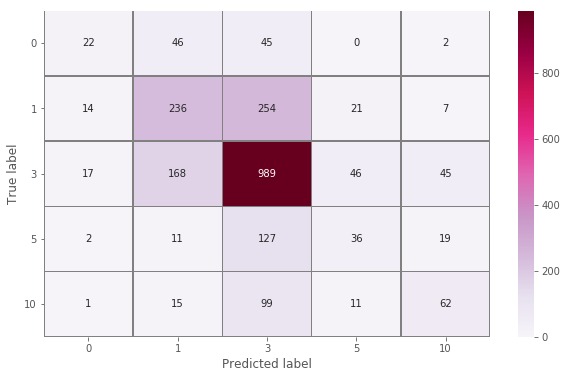

Wall time: 250 ms


In [60]:
%%time
text_clf = MultinomialNB(alpha=0.005)

text_clf.fit(x_text_train, y_train)
test_predicted_mult = text_clf.predict(x_text_test)
train_predicted_mult = text_clf.predict(x_text_train)

Report(y_train, y_test, train_predicted_mult, test_predicted_mult)

#### LogisticRegression

Accuracy: 
on train set 0.6569716775599128
on test set 0.5843137254901961
Report: 
             precision    recall  f1-score   support

          0       0.61      0.10      0.17       115
          1       0.51      0.27      0.35       532
          3       0.60      0.93      0.73      1265
          5       0.20      0.01      0.02       195
         10       0.50      0.03      0.05       188

avg / total       0.54      0.58      0.50      2295

Count of true predictions:  1341


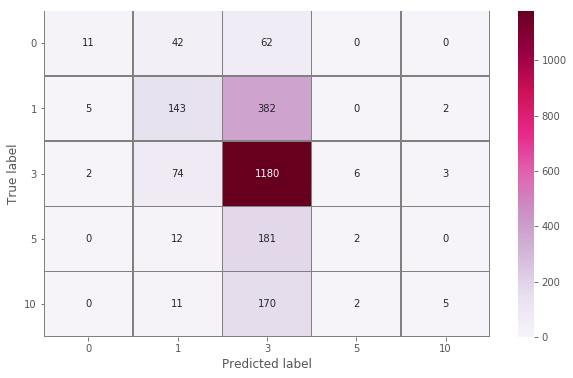

Wall time: 47.6 s


In [61]:
%%time

lr_clf = LogisticRegression(solver ='newton-cg', multi_class='multinomial', penalty='l2', C=100)
lr_clf.fit(x3_train, y_train)
test_predicted_lr = lr_clf.predict(x3_test)
train_predicted_lr = lr_clf.predict(x3_train)

Report(y_train, y_test, train_predicted_lr, test_predicted_lr)

#### LightGBM

In [62]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'learning_rate': 0.025,
    'max_depth': 80,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2}

In [63]:
lb = LabelEncoder()
y_enc = lb.fit_transform(y_train)
y_test_enc = lb.fit_transform(y_test)
train_data = lgb.Dataset(x1_train, label=y_enc)
test_data = lgb.Dataset(x1_test, label=y_test_enc)

In [64]:
%%time
model = lgb.train(params,
                       train_data,
                       valid_sets=test_data,
                       num_boost_round=2000,
                       early_stopping_rounds=150)

[1]	valid_0's multi_logloss: 1.59128
Training until validation scores don't improve for 150 rounds.
[2]	valid_0's multi_logloss: 1.57372
[3]	valid_0's multi_logloss: 1.55709
[4]	valid_0's multi_logloss: 1.54117
[5]	valid_0's multi_logloss: 1.52577
[6]	valid_0's multi_logloss: 1.5113
[7]	valid_0's multi_logloss: 1.49739
[8]	valid_0's multi_logloss: 1.48403
[9]	valid_0's multi_logloss: 1.47102
[10]	valid_0's multi_logloss: 1.4585
[11]	valid_0's multi_logloss: 1.44645
[12]	valid_0's multi_logloss: 1.43481
[13]	valid_0's multi_logloss: 1.4235
[14]	valid_0's multi_logloss: 1.41271
[15]	valid_0's multi_logloss: 1.40221
[16]	valid_0's multi_logloss: 1.39203
[17]	valid_0's multi_logloss: 1.38213
[18]	valid_0's multi_logloss: 1.37276
[19]	valid_0's multi_logloss: 1.36359
[20]	valid_0's multi_logloss: 1.35479
[21]	valid_0's multi_logloss: 1.34649
[22]	valid_0's multi_logloss: 1.33822
[23]	valid_0's multi_logloss: 1.33011
[24]	valid_0's multi_logloss: 1.32215
[25]	valid_0's multi_logloss: 1.31474

[214]	valid_0's multi_logloss: 1.02761
[215]	valid_0's multi_logloss: 1.02747
[216]	valid_0's multi_logloss: 1.02719
[217]	valid_0's multi_logloss: 1.02692
[218]	valid_0's multi_logloss: 1.02682
[219]	valid_0's multi_logloss: 1.02658
[220]	valid_0's multi_logloss: 1.02638
[221]	valid_0's multi_logloss: 1.02627
[222]	valid_0's multi_logloss: 1.02603
[223]	valid_0's multi_logloss: 1.02583
[224]	valid_0's multi_logloss: 1.02558
[225]	valid_0's multi_logloss: 1.02537
[226]	valid_0's multi_logloss: 1.02519
[227]	valid_0's multi_logloss: 1.02518
[228]	valid_0's multi_logloss: 1.02518
[229]	valid_0's multi_logloss: 1.02488
[230]	valid_0's multi_logloss: 1.02478
[231]	valid_0's multi_logloss: 1.02445
[232]	valid_0's multi_logloss: 1.02418
[233]	valid_0's multi_logloss: 1.02412
[234]	valid_0's multi_logloss: 1.02391
[235]	valid_0's multi_logloss: 1.02377
[236]	valid_0's multi_logloss: 1.02357
[237]	valid_0's multi_logloss: 1.0234
[238]	valid_0's multi_logloss: 1.02332
[239]	valid_0's multi_logl

[426]	valid_0's multi_logloss: 1.01132
[427]	valid_0's multi_logloss: 1.01132
[428]	valid_0's multi_logloss: 1.01134
[429]	valid_0's multi_logloss: 1.01139
[430]	valid_0's multi_logloss: 1.01152
[431]	valid_0's multi_logloss: 1.01149
[432]	valid_0's multi_logloss: 1.01156
[433]	valid_0's multi_logloss: 1.01151
[434]	valid_0's multi_logloss: 1.01148
[435]	valid_0's multi_logloss: 1.01139
[436]	valid_0's multi_logloss: 1.01128
[437]	valid_0's multi_logloss: 1.01127
[438]	valid_0's multi_logloss: 1.01131
[439]	valid_0's multi_logloss: 1.01131
[440]	valid_0's multi_logloss: 1.01126
[441]	valid_0's multi_logloss: 1.0112
[442]	valid_0's multi_logloss: 1.01137
[443]	valid_0's multi_logloss: 1.01146
[444]	valid_0's multi_logloss: 1.01141
[445]	valid_0's multi_logloss: 1.01134
[446]	valid_0's multi_logloss: 1.01136
[447]	valid_0's multi_logloss: 1.0114
[448]	valid_0's multi_logloss: 1.01133
[449]	valid_0's multi_logloss: 1.01139
[450]	valid_0's multi_logloss: 1.01139
[451]	valid_0's multi_loglo

[637]	valid_0's multi_logloss: 1.01514
[638]	valid_0's multi_logloss: 1.01516
[639]	valid_0's multi_logloss: 1.01522
[640]	valid_0's multi_logloss: 1.01529
[641]	valid_0's multi_logloss: 1.01528
[642]	valid_0's multi_logloss: 1.01538
[643]	valid_0's multi_logloss: 1.01541
[644]	valid_0's multi_logloss: 1.01535
[645]	valid_0's multi_logloss: 1.01531
[646]	valid_0's multi_logloss: 1.01529
[647]	valid_0's multi_logloss: 1.01533
[648]	valid_0's multi_logloss: 1.01536
[649]	valid_0's multi_logloss: 1.01536
[650]	valid_0's multi_logloss: 1.01544
Early stopping, best iteration is:
[500]	valid_0's multi_logloss: 1.01095
Wall time: 1min 42s


In [65]:
y_predictions = model.predict(x1_test)

In [66]:
test_predicted = []
for y in y_predictions:
    test_predicted.append(np.argmax(y))

In [67]:
accuracy_test = accuracy_score(y_test_enc, test_predicted)

Accuracy on test set: 0.6026143790849673
Report: 
             precision    recall  f1-score   support

          0       0.42      0.12      0.19       115
          1       0.54      0.38      0.45       532
          2       0.63      0.88      0.73      1265
          3       0.47      0.07      0.12       195
          4       0.49      0.19      0.27       188

avg / total       0.57      0.60      0.55      2295

Sum of true predictions:  1383


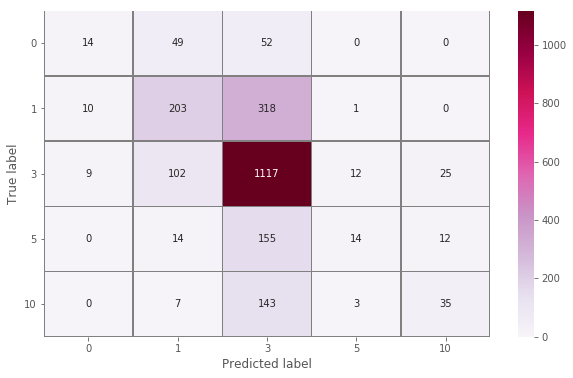

In [68]:
report = classification_report(y_test_enc, test_predicted)
cm = confusion_matrix(y_test_enc, test_predicted)

print("Accuracy on test set:", accuracy_test)
print("Report: "+"\n"+ report)
print("Sum of true predictions: ", cm.diagonal().sum())

labels = sorted(y_test.unique())
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
fig = plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_cm, annot=True, cmap='PuRd', 
                      linewidths=.5, linecolor='gray',fmt="d", cbar_kws={"orientation": "vertical"})
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

From the above models LightGBM shows the highest f1_score

#### Parameter tuning using grid search with cross-validation

In [69]:
classifiers = dict()

In [70]:
# RandomForest
parameters = {'n_estimators':range(10,100,5), 'max_depth':range(10,50,5)}
forest = RandomForestClassifier(random_state=1)
clf = GridSearchCV(forest, parameters, cv=4, scoring='f1_macro', n_jobs=2)
clf.fit(x4_train, y_train)
print(clf.best_params_)
classifiers['Random Forest'] = clf.best_estimator_

{'max_depth': 25, 'n_estimators': 10}


In [71]:
# Decision Tree
parameters = {'max_depth': range(10, 50, 2), 'min_samples_split' :range(10, 50, 2)}
tree = DecisionTreeClassifier(random_state=1)
clf = GridSearchCV(tree, parameters, cv=4, scoring='f1_macro', n_jobs=2)
clf.fit(x2_train, y_train)
print(clf.best_params_)
classifiers['Decision Tree'] = clf.best_estimator_

{'max_depth': 42, 'min_samples_split': 16}


In [72]:
# Naive Bayes
parameters = {'alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}
mult = MultinomialNB()
clf = GridSearchCV(mult, parameters, cv=4, scoring='f1_macro', n_jobs=2)
clf.fit(x_text_train, y_train)
print(clf.best_params_)
classifiers['Naive Bayes'] = clf.best_estimator_

{'alpha': 0.001}


In [74]:
# LogisticRegression
parameters = {'C':[0.01, 0.1, 1, 10, 100], 'penalty':['l1','l2']}
lr = LogisticRegression(max_iter = 1000, random_state=1)
clf = GridSearchCV(lr, parameters, cv=4, scoring='f1_macro', n_jobs=2)
clf.fit(x3_train, y_train)
print(clf.best_params_)
classifiers['Logistic Regression'] = clf.best_estimator_

{'C': 100, 'penalty': 'l2'}


In [75]:
# Add LightGbm parameters
classifiers['Light GBM'] = params

In [76]:
classifiers

{'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=25, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=1, verbose=0, warm_start=False),
 'Decision Tree': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=42,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=16,
             min_weight_fraction_leaf=0.0, presort=False, random_state=1,
             splitter='best'),
 'Naive Bayes': MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True),
 'Logistic Regression': LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
           intercept_sc

### Stacked Ensemble

In [77]:
def trainMeta(X1, X2, X3, X4, X_text, Y, classifiers):
    '''
    prepare X-meta train dataset with predictions made by all classifiers as columns
    '''
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    y_pred_train_oof = pd.DataFrame({'Naive Bayes': np.zeros(Y.shape),                                    
                                   'Light GBM': np.zeros(Y.shape),
                                   'Random Forest':  np.zeros(Y.shape),
                                   'Decision Tree':  np.zeros(Y.shape),
                                   'Logistic regression':  np.zeros(Y.shape)})
    lb = LabelEncoder()
    y_enc = lb.fit_transform(Y)
    for trainIdx, testIdx in cv.split(X1, Y):
        for k,v in classifiers.items():
            if k =='Light GBM':
                train_data = lgb.Dataset(X1.toarray()[trainIdx], label=y_enc[trainIdx])
                model = lgb.train(v, train_data, num_boost_round=2000)
                y_predictions = model.predict(X1.toarray()[testIdx])
                test_predicted = []
                for y in y_predictions:
                    test_predicted.append(np.argmax(y))
                y_pred_train_oof['Light GBM'].iloc[testIdx] = test_predicted
            elif k == 'Naive Bayes':
                v.fit(X_text.toarray()[trainIdx], Y.values[trainIdx])
                test_predicted = v.predict(X_text.toarray()[testIdx])
                y_pred_train_oof['Naive Bayes'].iloc[testIdx] = test_predicted
            elif k == 'Random Forest':
                v.fit(X4.values[trainIdx], Y.values[trainIdx])
                test_predicted = v.predict(X4.values[testIdx])
                y_pred_train_oof['Random Forest'].iloc[testIdx] = test_predicted
            elif k == 'Decision Tree':
                v.fit(X2.toarray()[trainIdx], Y.values[trainIdx])
                test_predicted = v.predict(X2.toarray()[testIdx])
                y_pred_train_oof['Decision Tree'].iloc[testIdx] = test_predicted
            elif k == 'Logistic Regression':
                v.fit(X3.toarray()[trainIdx], Y.values[trainIdx])
                test_predicted = v.predict(X3.toarray()[testIdx])
                y_pred_train_oof['Logistic regression'].iloc[testIdx] = test_predicted

    return y_pred_train_oof

In [78]:
def testMeta(x1_train, x2_train, x3_train, x4_train, x_text_train, y_train, 
             x1_test, x2_test, x3_test, x4_test, x_text_test,
             classifiers):
    '''
    prepare X-meta test dataset 
    '''
    len_test_df = x1_test.shape[0]
    y_pred_test_oof = pd.DataFrame({'Naive Bayes': np.zeros(len_test_df), 
                                   'Light GBM': np.zeros(len_test_df),
                                   'Random Forest':  np.zeros(len_test_df),
                                   'Decision Tree':  np.zeros(len_test_df),
                                   'Logistic regression':  np.zeros(len_test_df)})
    lb = LabelEncoder()
    y_enc_train = lb.fit_transform(y_train)
    for k,v in classifiers.items():
        if k =='Light GBM':
            train_data = lgb.Dataset(x1_train, label=y_enc_train)
            model = lgb.train(v,train_data,num_boost_round=2000)
            y_predictions = model.predict(x1_test)
            test_predicted = []
            for y in y_predictions:
                test_predicted.append(np.argmax(y))
            y_pred_test_oof['Light GBM']= test_predicted
        elif k == 'Naive Bayes':
            v.fit(x_text_train, y_train)
            test_predicted = v.predict(x_text_test)
            y_pred_test_oof['Naive Bayes'] = test_predicted
        elif k == 'Random Forest':
            v.fit(x4_train, y_train)
            test_predicted = v.predict(x4_test)
            y_pred_test_oof['Random Forest'] = test_predicted
        elif k == 'Decision Tree':
            v.fit(x2_train, y_train)
            test_predicted = v.predict(x2_test)
            y_pred_test_oof['Decision Tree'] = test_predicted
        elif k == 'Logistic Regression':
            v.fit(x3_train, y_train)
            test_predicted = v.predict(x3_test)
            y_pred_test_oof['Logistic regression'] = test_predicted

    return y_pred_test_oof

In [79]:
X_meta_train = trainMeta(x1_train, x2_train, x3_train, x4_train, x_text_train, y_train, classifiers).astype(int)

In [80]:
X_meta_test = testMeta(x1_train, x2_train, x3_train, x4_train, x_text_train, y_train, 
                       x1_test, x2_test, x3_test, x4_test, x_text_test,
                       classifiers)

In [81]:
X_meta_test

,Naive Bayes,Light GBM,Random Forest,Decision Tree,Logistic regression
0,3,2,3,5,1
1,3,2,3,3,3
2,3,2,3,3,3
3,3,2,3,3,3
4,1,1,0,1,1
5,1,2,3,0,1
6,3,2,3,3,10
7,5,2,1,1,3
8,1,2,3,3,3
9,1,2,1,3,3


In [82]:
pd.concat([X_meta_train, y_train], axis=1).to_csv('meta_train.csv', index=False)
pd.concat([X_meta_test, y_test], axis=1).to_csv('meta_test.csv', index=False)

Create new train & test datasets where predictions of 5 models and some selected features are combined:

In [83]:
df1_train = x4_train[['author_name_enc','author_email_domain_enc','committer_name_enc', 'committer_email_domain_enc','components_enc','head_message_len_text',
                     'message_lines_count','month','day', 'weekday', 'hour', 'year_enc']]
df1_test = x4_test[['author_name_enc','author_email_domain_enc','committer_name_enc', 'committer_email_domain_enc','components_enc','head_message_len_text',
                     'message_lines_count','month','day', 'weekday', 'hour', 'year_enc']]
df1_train.reset_index(drop=True, inplace=True)
df1_test.reset_index(drop=True, inplace=True)
X_new_train = pd.concat([X_meta_train, df1_train], axis=1)
X_new_test = pd.concat([X_meta_test, df1_test], axis=1)

### Light GBM for metamodelling

In [84]:
params_meta = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'learning_rate': 0.01,
    'max_depth': 40,
    'num_leaves': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 2}

In [85]:
train_data = lgb.Dataset(X_new_train, label=y_enc)
model = lgb.train(params_meta,train_data,num_boost_round=2000)
y_predictions = model.predict(X_new_test)

In [86]:
test_predicted = []
for y in y_predictions:
    test_predicted.append(np.argmax(y))

Accuracy on test set: 0.6183006535947713
Report: 
             precision    recall  f1-score   support

          0       0.45      0.13      0.20       115
          1       0.54      0.44      0.49       532
          2       0.65      0.88      0.75      1265
          3       0.41      0.06      0.11       195
          4       0.52      0.23      0.32       188

avg / total       0.58      0.62      0.57      2295

Sum of true predictions:  1419


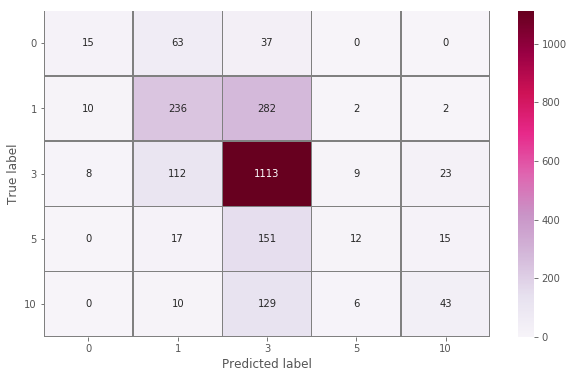

In [87]:
accuracy_test = accuracy_score(y_test_enc, test_predicted)
report = classification_report(y_test_enc, test_predicted)
cm = confusion_matrix(y_test_enc, test_predicted)

print("Accuracy on test set:", accuracy_test)
print("Report: "+"\n"+ report)
print("Sum of true predictions: ", cm.diagonal().sum())

labels = sorted(y_test.unique())
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
fig = plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_cm, annot=True, cmap='PuRd', 
                      linewidths=.5, linecolor='gray',fmt="d", cbar_kws={"orientation": "vertical"})
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [88]:
importances = pd.DataFrame(np.array([pd.Series(X_new_train.columns), pd.Series(model.feature_importance()*100./np.sum(model.feature_importance()))]).transpose(),
                          columns=["Name", "Importance"]).sort_values('Importance', ascending=False)
importances

,Name,Importance
5,author_name_enc,11.801
10,head_message_len_text,11.597
9,components_enc,9.686
11,message_lines_count,9.183
13,day,9.012
6,author_email_domain_enc,7.101
15,hour,6.973
7,committer_name_enc,6.716
12,month,6.566
14,weekday,4.148


Ensemble gives better accuracy than individual algorithms while f1_score is the best too.

### 2. Для проверки вашего уровня технического английского переведите текст на русский или украинский:

Thankfully, the data is already in a simple CSV format and does not require much cleansing or other preparation to be used with Spark MLlib. Later, it will be of interest to explore some transformations of the data, but it can be used as is to start. The covtype.data file should be extracted and copied into HDFS. This chapter will assume that the file is available at /user/ds/. Start spark-shell.
The Spark MLlib abstraction for a feature vector is known as a LabeledPoint, which consists of a Spark MLlib Vector of features, and a target value, here called the label. The target is a Double value, and Vector is essentially an abstraction on top of many Double values. This suggests that LabeledPoint is only for numeric features. It can be used with categorical features, with appropriate encoding.
One such encoding is one-hot or 1-of-n encoding, in which one categorical feature that takes on N distinct values becomes N numeric features, each taking on the value 0 or 1. Exactly one of the N values has value 1, and the others are 0. For example, a categorical feature for weather that can be cloudy, rainy, or clear would become three numeric features, where cloudy is represented by 1,0,0; rainy by 0,1,0; and so on. These three numeric features might be thought of as is_cloudy, is_rainy, and is_clear features. Another possible encoding simply assigns a distinct numeric value to each possible
value of the categorical feature. For example, cloudy may become 1.0, rainy 2.0, and so on.

Добре, що дані представлені в простому CSV-форматі та не потребують очищення або інших дій для використання в Spark MLlib. В подальшому, можливо, буде цікаво дослідити деякі перетворення даних, але для початку їх уже можна застосовувати без перетворень. Дані з covtype.data файлу розпаковуються і копіюються в HDFS (Hadoop Distributed File System). У цьому розділі припускається, що файл доступний на /user/ds. Запускаємо spark-shell. Spark MLlib абстракція для вектора фіч називається LabeledPoint, вона складається з вектора фіч Spark MLlib і цільової змінної, яку будемо називатимети лейблом(міткою). Мітка - це значення в Double форматі, а вектор - по суті, абстракція з багатьох значень Double формату. Це є передумовою того, що LabeledPoint можна використовувати лише для числових ознак. До категоріальних ознак LabeledPoint застосовується лише після відповідного кодування. Наприклад, one-hot або 1-of-n кодування, в якому категоріальна змінна з N можливими значеннями перетворюється на N числових змінних, що набувають значення 0 або 1. Одне значення з N дорівнює 1, а інші 0. Наприклад, категорія Погода, яка може приймати значення Хмарна, Дощова або Ясна, закодується трьома векторами: Хмарна = (1,0,0); Дощова = (0,1,0); Ясна = (0,0,1). Ці три чисельні змінні можна розглядатися як змінні, що відповідають типам погоди: Хмарна, Дощова та Ясна. Інше можливе кодування (цілочисельне) просто ставить у відповідність єдине числове значення кожному можливому значенню категорійної ознаки. Наприклад, Хмарна=1, Дощова=2 тощо.